In [43]:
# dobra to generalnie nie bardzo wiem co wiecie ani co sie nam przyda, więc po prostu potrenujemy sb różnego typu sieci do rozpoznawania obrazków, na milion różnych sposobów.
# prawodopodobnie będzie wszystko zrobione wałśnie na colab bo jest darmowe dla studentów i daje dostęp do akceleracji gpu/tpu także to też tutaj napisze
# że colab jest od googla to będziemy używać TensorFlow, jest jeszcze pytorch od facebooka.
# jakiejś większej różnicy między nimi nie ma, można sobie kodzik z jednego na drugi przepisać w mniej niż godzine zazwyczaj

In [44]:
# najpierw importujemy sobie biblioteki
!pip install tensorflow
!pip install tensorflow_datasets
!pip install matplotlib
!pip install numpy
!pip3 install visualkeras
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import visualkeras

In [45]:
# do trenowania czegokolwiek potrzebujemy oczywiście danych, potrenujemy sobie model do rozpoznawania narysowanych cyfr, później ubrań na datasecie przygotowanym przez zalando (mnist-fashion)
# potrzebujemy oddzielnych datasetów do trenowania i do oceny modelu, także ten główny trzeba podzielić na dwa
# nie ma jakichś ścisłych reguł odnośnie tego w jakiej proporcji to dzielimy, ale nie mniej niż połowa danych powinna trafić do training_dataset i nie mniej niż 10% do testing_dataset.
# oczywiście im mniej danych damy do testu, tym mniej warte będą te wyniki bo nie wiemy czego dokładnie ten model się nauczył i czy napewno nauczył się wszystkiego
# im więcej (i im bardziej różnorodne) dane mamy do trenowania tym generalnie lepszy będzie nasz model

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',  #nazwa datasetu
    split=['train', 'test'],  #podział na sub-datasety, czasami używa się też trzeciego jako takiego ostatecznego testu po całym treningu żeby mieć pewność że model działa na danych których nigdy nie widział
    shuffle_files=True,   #przetasowujemy obrazki żeby nasz train i test dataset zawierały podobną ilość każdego typu cyfry czy tam ubrania (bo jeśli w train będą cyfry od 0-7 a w test od 8-9 to zarówno trening jak i test są bezwartościowe)
    as_supervised=True, #nwm o co tu chodzi, zajebałem ten kod z poradnika
    with_info=True, #tu też nwm o co chodzi
)

In [46]:
# dane w tym datasecie to macierze o rozmiarze 28x28 w formacie int8, mamy tylko biały kanał, więc macierz jest jednowymiarowa
# wszystkie *WSZYSTKIE* dane które trafiają i wychodzą z modelu muszą być w formacie float32 (znaczy niekoniecznie ale dla naszych potrzeb możemy założyć że tak musi być)
# dlatego musimy je scastować, można to zrobić ręcznie w pythonie ale użyjemy kolejnej funkcji podpierdzielonej z poradnika

# tak btw, jak najedziecie sobie kursorem na daną funkcję to pokaże się jej wytłumaczenie, dlatego nie wyszystko będę pisał w komentarzach, sugeruję sobie najechać na funkcję "map" poniżej

def cast_img(image, label):
  return tf.cast(image, tf.float32) / 255., label     # dzielimy przez 255 bo redukujemy liczbę z przedziału 0-255, do float z przedziału 0.0-1.0

# trenowanie nie odbywa się "na raz"
# ponieważ nie mamy nieograniczonej ilości danych, będziemy używali tego samego datasetu wielokrotnie, jedno przejście przez cały dataset nazywa się "epoch"
# przepuszczenie wszystkich możliwych danych przez model na raz i wprowadzenie jakichś zmian po tym ma mało sensu, bo zajmie wieki (z racji rzadkich aktualizacji modelu)
# dlatego taki dataset dzielimy na mniejsze kawałki nazywane "batch", i po każdym batchu możemy sobie troche poprawić model
# dane zajmują też miejsce cnie, więc jeśli nie mamy nieskończonej ilości pamięci dostępnej do wykonywania operacji (np na gpu w postaci pamięci graficznej), to też będziemy stosować batche,
# bo wtedy tylko ten batch (i może następny żebyśmy nie musieli czekać z trenowaniem aż się prześle, tak przesyłanie danych w komputerze zajmuje masę czasu) jest na karcie, a nie cały dataset
# dataset testowy możemy przepuścić przez model na raz (o ile mamy tyle ramu), ale i tak go podzielimy bo czemu nie
# danych testowych nie będziemy tasować, bo nei wprowadzamy zmian w modelu wiec nic to nie zmieni
# a i nie wiem czy o tym napisałem, ale tasujemy dane w treningu też po to, że jakbyśmy najpierw uczyli rozpoznawać same jedynki, potem same dwójki, to model jak się nauczy dwójki to już zapomni czym jest jedynka
# dane muszą być równomierne

# date treningowe
ds_train = ds_train.map(
    cast_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# dane testowe
ds_test = ds_test.map(
    cast_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [47]:
# mamy dane to teraz jakiś prosty model, oczywiście podjebany z poradnika, moje inwencje będą później

model = tf.keras.models.Sequential([              # sequential to taki for loop, który jak dostanie dane, to wkłada do pierwszego layera, wynik z pierwszego daje do drugiego itd
  tf.keras.layers.Flatten(input_shape=(28, 28)),  # zmieniamy macierz na array, bo cała reszta modelu to arraye (później nie będziemy tego robić, bo reszta modelu też będzie macierzami)
  tf.keras.layers.Dense(128, activation='relu'),  # activation functions pamiętacie, a dense to array weightów, taka basic sieć neuronowa
  tf.keras.layers.Dense(10)                       # ponieważ chcemy klasyfikować obrazki do cyfr 0-9, ostatni layer będzie służył do klasyfikacji, każda komórka w tym layerze po wsadzeniu obrazka będzie miała jakąś tam wartość
                                                  # uznajemy, że wartości reprezentują prawdopodobieństwo i że największa wartość daje nam odpowiedź co jest na obrazku (image label)
                                                  # wartości mogą być jakiekolwiek, interesuje nas tylko że największa (predykcja modelu) zgadza się z faktycznym podpisem obrazka
])

# tworzymy sobie model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),                              # optimizer to funkcja trenująca model, są różne np sgd (działa zawsze praktycznie ale nei jest najlepszy), adam właśnie (mocno zmodyfikowany sgd), ada, adagrad i różne wariacje tych, używamy adama bo jest generalnie git
                                                                            # określamy też learning rate, im wiekszy learning rate tym szybiciej model się trenuje, ale ostateczne wyniki nie będą najlepsze, to chyba pamiętacie od dębskiego
                                                                            # są techniki zaradzenia temu ale o nich później
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   # funkcja straty (jak bardzo źle model przewiduje), optimizer patrzy co może zmienić w modelu żeby wynik tej funkcji się zmniejszył
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],                 # funkcja loss musi na czymś działać i u nas będzie to własnie categorical accuracy, zwykłe accuracy trenowałoby model też w taki sposób, że ma być pewien że coś jest daną liczbą i jednocześnie że nie jest inną.
                                                                            # zależy nam tylko na tym czym ta liczba jest, mamy wywalone czy model się zastanawia czy 1 przypadkiem nie jest podobne do 7, jak mówi że 1 to 1, jest to bardziej efektywne w problemach klasyfikacji
)

# trenujemy model
model.fit(
    ds_train, # dataset treningowy
    epochs=6, # ilość epochów tłumaczonych wyżej
    validation_data=ds_test,  # dataset testowy
)

Epoch 1/6


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6181 - sparse_categorical_accuracy: 0.8320 - val_loss: 0.2019 - val_sparse_categorical_accuracy: 0.9416
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1811 - sparse_categorical_accuracy: 0.9484 - val_loss: 0.1407 - val_sparse_categorical_accuracy: 0.9583
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.9644 - val_loss: 0.1102 - val_sparse_categorical_accuracy: 0.9663
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.0953 - val_sparse_categorical_accuracy: 0.9715
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0731 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.0914 - val_sparse_categorical_accuracy: 0.9716
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0604 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.0846 - val_sparse_categorical_accuracy: 0.9732


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


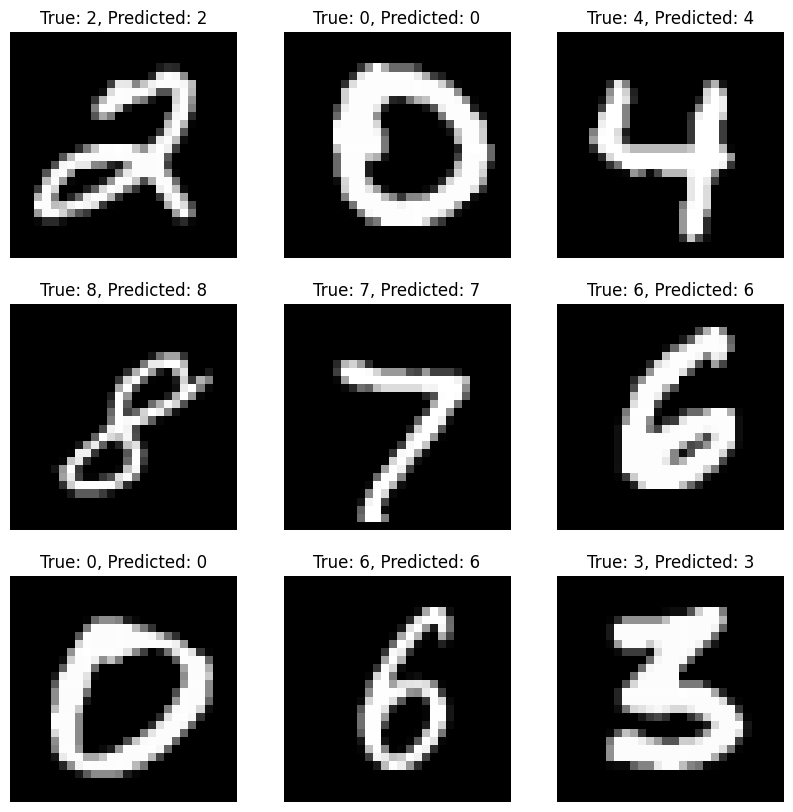

In [48]:
# mamy wytrenowany model to teraz zobaczymy sobie co on tam sie nauczył

# bierzemy 9 obrazków
for images, labels in ds_test.take(1):
    sample_images = images[:9]
    sample_labels = labels[:9]

# wsadzamy do modelu, bierzemy największą predykcję jako odpowiedź
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# rysujemy plota
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f'True: {sample_labels[i]}, Predicted: {predicted_labels[i]}')
    plt.axis('off')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


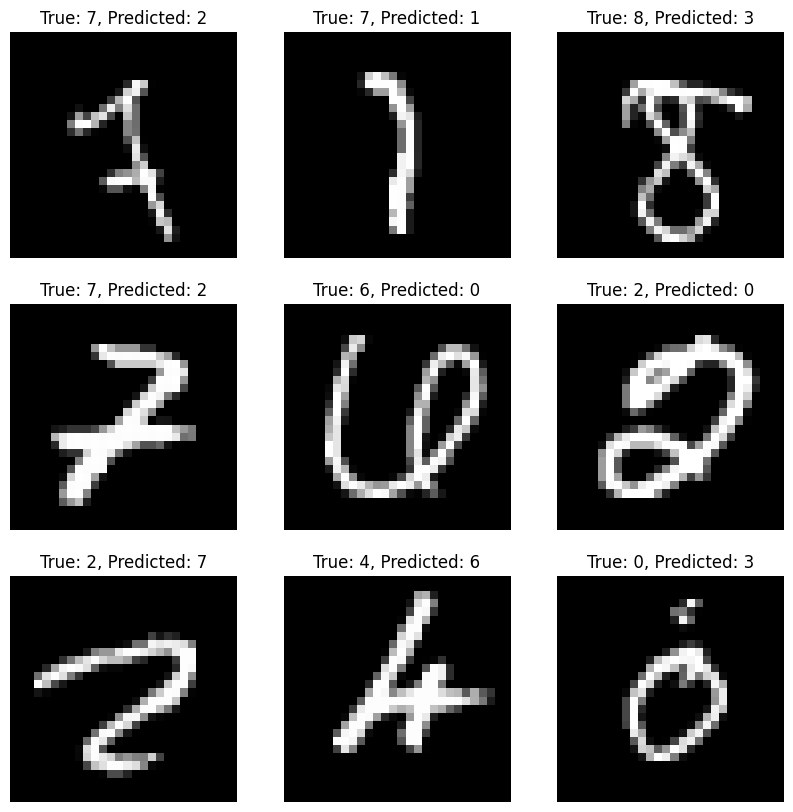

In [49]:
# nie ma lipy, to teraz na czym sie wywalił

import matplotlib.pyplot as plt
import numpy as np

misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

# sprawdzamy obrazki tak długo aż dostaniemy 9 źle sklasyfikowanych
for images, labels in ds_test:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    misclassified_indices = np.where(labels.numpy() != predicted_labels)[0]

    for idx in misclassified_indices:
        misclassified_images.append(images[idx])
        misclassified_true_labels.append(labels[idx])
        misclassified_predicted_labels.append(predicted_labels[idx])

        if len(misclassified_images) == 9:
            break

    if len(misclassified_images) == 9:
        break

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(misclassified_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'True: {misclassified_true_labels[i]}, Predicted: {misclassified_predicted_labels[i]}')
    plt.axis('off')
plt.show()

In [50]:
# 98% (czy jaki tam był finalny wynik) to git, ale cyferki są proste
# ładujemy ubrania
# * tu macie listę datasetów https://www.tensorflow.org/datasets/catalog/overview?hl=pl#all_datasets

(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist',    # nowy dataset
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
len(ds_train), len(ds_test)

# date treningowe
ds_train = ds_train.map(
    cast_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# dane testowe
ds_test = ds_test.map(
    cast_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [51]:
# deklarujemy nowy model (nadpisujemy stary)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7466 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.4691 - val_sparse_categorical_accuracy: 0.8378
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4105 - sparse_categorical_accuracy: 0.8564 - val_loss: 0.4431 - val_sparse_categorical_accuracy: 0.8437
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3700 - sparse_categorical_accuracy: 0.8678 - val_loss: 0.4096 - val_sparse_categorical_accuracy: 0.8571
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3378 - sparse_categorical_accuracy: 0.8798 - val_loss: 0.4060 - val_sparse_categorical_accuracy: 0.8587
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3183 - sparse_categorical_accuracy: 0.8855 - val_loss: 0.3624 - val_sparse_categorical_accuracy: 0.8745
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3038 - sparse_categorical_accuracy: 0.8894 - val_loss: 0.3957 - val_sparse_categorical_accuracy: 0.8622


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


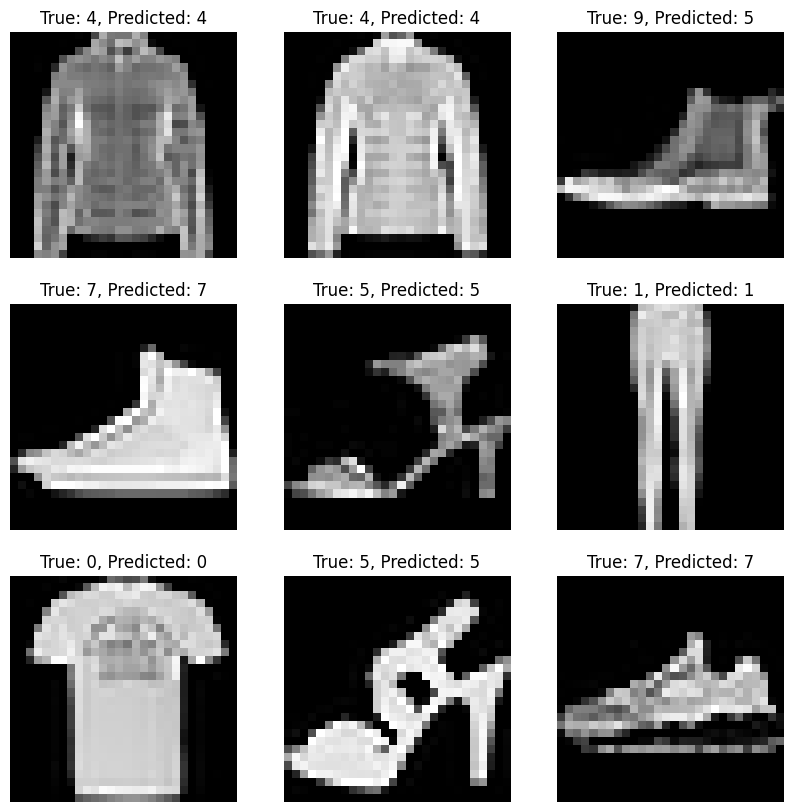

In [52]:
for images, labels in ds_test.take(1):
    sample_images = images[:9]
    sample_labels = labels[:9]

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f'True: {sample_labels[i]}, Predicted: {predicted_labels[i]}')
    plt.axis('off')
plt.show()

In [53]:
# ogólnie myślałem że będzie mega słabo, ale ubranka sa ewidentnie dalej za łatwe, ładujemy kolorowe zdjęcia z setką klas

(ds_train, ds_test), ds_info = tfds.load(
    'cifar100',    # nowy dataset
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
len(ds_train), len(ds_test)


# nie ufam tasowaniu z loadera więc zrobię po swojemu
len_test =  len(ds_test)
combined = ds_train.concatenate(ds_test)
combined = ds_train.shuffle(len(combined))
ds_train = combined.take(int(len(combined)*0.85))
ds_test = combined.skip(int(len(combined)*0.85))
len(ds_train), len(ds_test)

class_names = ds_info.features['label'].names # pomocnicze dla nas, bo teraz nei obchodzi nas że klasa 59, tylko chcemy wiedzieć że to koń

ds_train = ds_train.map(
    cast_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    cast_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [54]:
# zdjęcia są 32x32 i kolorowe, więc rozmiar inputu to teraz 32x32x3
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100)
])

In [55]:


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5696 - sparse_categorical_accuracy: 0.0192 - val_loss: 4.3145 - val_sparse_categorical_accuracy: 0.0447
Epoch 2/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2382 - sparse_categorical_accuracy: 0.0509 - val_loss: 4.0124 - val_sparse_categorical_accuracy: 0.0824
Epoch 3/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9780 - sparse_categorical_accuracy: 0.0835 - val_loss: 3.9269 - val_sparse_categorical_accuracy: 0.0932
Epoch 4/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9012 - sparse_categorical_accuracy: 0.0998 - val_loss: 3.8488 - val_sparse_categorical_accuracy: 0.1093
Epoch 5/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8687 - sparse_categorical_accuracy: 0.1069 - val_loss: 3.8194 - val_sparse_categorical_accuracy: 0.1155
Epoch 6/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8388 - sparse_categorical_accuracy: 0.1127 - val_loss: 3.7825 - val_sparse_categorical_accuracy: 0.1231


In [56]:
# visualkeras.layered_view(model) # znalazłem taką fajną funkcję do wizualizacji modelu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


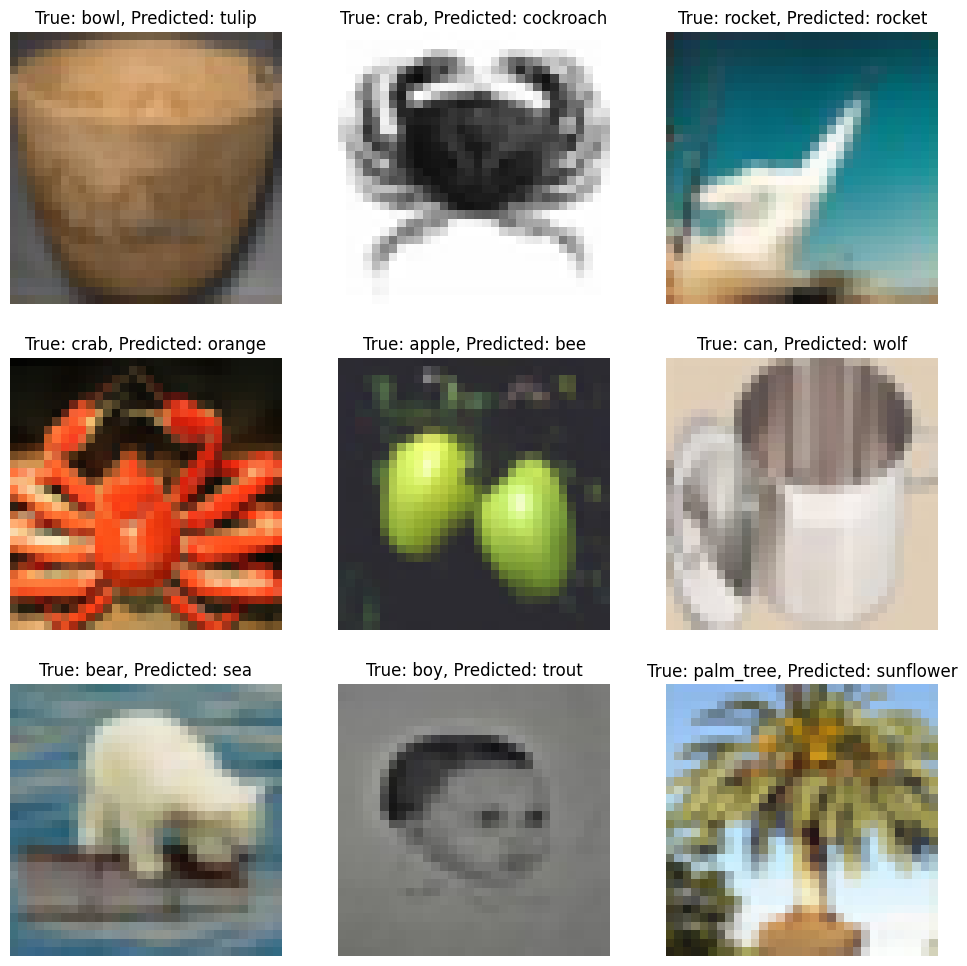

In [57]:
ds_test_shuffled = ds_test.shuffle(buffer_size=len(ds_test))

for images, labels in ds_test_shuffled.take(1):
    sample_images = images[:9]
    sample_labels = labels[:9]

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f'True: {class_names[sample_labels[i]]}, Predicted: {class_names[predicted_labels[i]]}')
    plt.axis('off')
plt.show()

In [58]:
# 13% zgaduje dobrze, nie jest dobrze
# dodamy więcej layerów

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.4242 - sparse_categorical_accuracy: 0.0314 - val_loss: 4.0363 - val_sparse_categorical_accuracy: 0.0751
Epoch 2/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9338 - sparse_categorical_accuracy: 0.0892 - val_loss: 3.7583 - val_sparse_categorical_accuracy: 0.1197
Epoch 3/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7166 - sparse_categorical_accuracy: 0.1249 - val_loss: 4.0695 - val_sparse_categorical_accuracy: 0.0985
Epoch 4/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6341 - sparse_categorical_accuracy: 0.1396 - val_loss: 3.5764 - val_sparse_categorical_accuracy: 0.1580
Epoch 5/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5039 - sparse_categorical_accuracy: 0.1609 - val_loss: 3.5608 - val_sparse_categorical_accuracy: 0.1476
Epoch 6/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.4236 - sparse_categorical_accuracy: 0.1707 - val_loss: 3.3346 - val_sparse_categorical_accuracy: 0.1955


In [59]:
# visualkeras.layered_view(model)

In [60]:
# 20% to dalej słabo, więc może większe layery

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(32*32, activation='relu'),    # wielkościami densów możecie się pobawić jak chcecie
  tf.keras.layers.Dense(32*32, activation='relu'),
  tf.keras.layers.Dense(32*16, activation='relu'),
  tf.keras.layers.Dense(32*8, activation='relu'),
  tf.keras.layers.Dense(32*4, activation='relu'),
  tf.keras.layers.Dense(100)  # tego nie ruszać, classification layer, odpowiada wielkością ilości klas w datasecie
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,   # możecie sb to pozmieniać na różne wartości żeby zobaczyć jak to wpływa na wynik
    validation_data=ds_test,
)

Epoch 1/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.5306 - sparse_categorical_accuracy: 0.0219 - val_loss: 4.1952 - val_sparse_categorical_accuracy: 0.0572
Epoch 2/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.0324 - sparse_categorical_accuracy: 0.0715 - val_loss: 3.8111 - val_sparse_categorical_accuracy: 0.1040
Epoch 3/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.7960 - sparse_categorical_accuracy: 0.1099 - val_loss: 3.7442 - val_sparse_categorical_accuracy: 0.1232
Epoch 4/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.6380 - sparse_categorical_accuracy: 0.1396 - val_loss: 3.5350 - val_sparse_categorical_accuracy: 0.1563
Epoch 5/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.5275 - sparse_categorical_accuracy: 0.1569 - val_loss: 3.4438 - val_sparse_categorical_accuracy: 0.1725
Epoch 6/6
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.4329 - sparse_categorical_accuracy: 0.1727 - val_loss: 3.3632 - val_sparse_categorical_accuracy: 0.1867


In [61]:
# wynik jest bardzo podobny co do mniejszego modelu.
# to znaczy że trenowaliśmy za krótko, ale szkoda mi czasu żeby to udowadniać eksperymentalnie  (większy model prawie zawsze powinien być lepszy, jak chcecie wiedzieć czemu nie zawsze to poczytajcie o "gradient implosion")
# zamiast tego przechodzimy do sieci konwolucyjnych, nie będę pisał jak działają, tu macie wytłumaczone wszystko pięknie wraz z live demo co się dzieje w takiej sieci: https://poloclub.github.io/cnn-explainer/

In [62]:
# ten model  ma znacznie lepsze wyniki bo architektura się bardziej nadaje do klasyfikacji zdjęć

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 3)),
  tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  tf.keras.layers.Flatten(),  # ponieważ konwolucje robimy na macierzach, a dalej mamy arraye, to musimy dane spłaszczyć (przerobić na array)
  tf.keras.layers.Dense(256, activation='relu'),  # zazwyczaj co najmniej jeden dense powinien zostać po blokach konwolucyjnych
  tf.keras.layers.Dense(100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=25,   # możecie sb to pozmieniać na różne wartości żeby zobaczyć jak to wpływa na wynik
    validation_data=ds_test,
)

Epoch 1/25


c:\Users\janic\anaconda3\envs\jupyter_ai\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 4.3135 - sparse_categorical_accuracy: 0.0559 - val_loss: 3.5679 - val_sparse_categorical_accuracy: 0.1697
Epoch 2/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 3.4881 - sparse_categorical_accuracy: 0.1896 - val_loss: 3.1902 - val_sparse_categorical_accuracy: 0.2372
Epoch 3/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 3.1157 - sparse_categorical_accuracy: 0.2550 - val_loss: 2.8988 - val_sparse_categorical_accuracy: 0.2893
Epoch 4/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.8587 - sparse_categorical_accuracy: 0.3070 - val_loss: 2.6957 - val_sparse_categorical_accuracy: 0.3383
Epoch 5/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.6353 - sparse_categorical_accuracy: 0.3491 - val_loss: 2.5570 - val_sparse_categorical_accuracy: 0.3655
Epoch 6/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.4626 - sparse_categorical_accuracy: 0.3834 - val_loss: 2.3408 - val_sparse_categorical_accuracy: 0.4155
Epoch 7/2

In [63]:
# visualkeras.layered_view(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


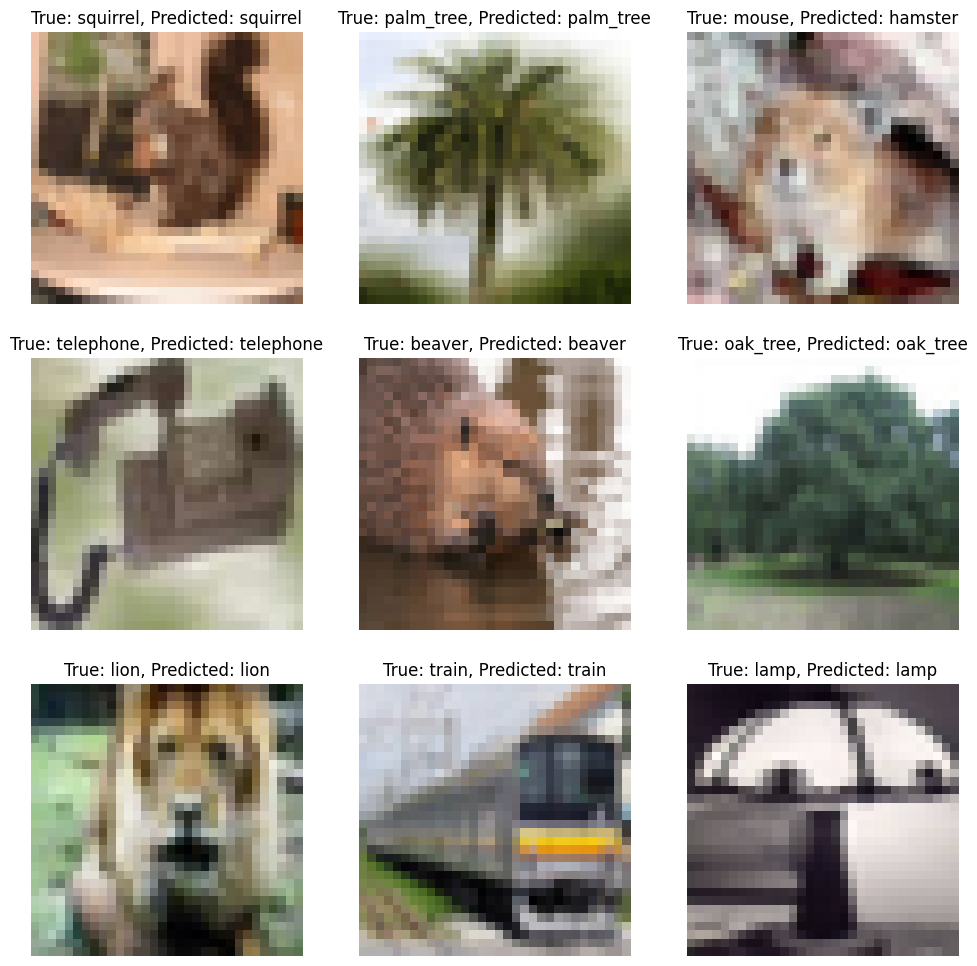

In [64]:
ds_test_shuffled = ds_test.shuffle(buffer_size=len(ds_test))

for images, labels in ds_test_shuffled.take(1):
    sample_images = images[:9]
    sample_labels = labels[:9]

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f'True: {class_names[sample_labels[i]]}, Predicted: {class_names[predicted_labels[i]]}')
    plt.axis('off')
plt.show()

In [65]:
# jak chcecie sie bardziej pouczyć o tym to możecie sb zrobić nowe modele korzystające z kolejnych elementów: dropout, batchnormalization, MaxPool2D, AveragePooling2D
# jesteście inteligentni, możecie zobaczyć jak to podłączyć do tego modelu xdd

In [66]:
# nudziło mi sie, enjoy xd

In [67]:
# a i generalnie, obecnie "state of the art" do obrazków (i alphazero okazuje się) są modele "residual networks" opisane tu https://arxiv.org/abs/1512.03385
# ale granie w szachy jak na to popatrzeć inaczej to patrzenie na obrazek i zmienianie tego obrazka

In [68]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(32, 32, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='selu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)

Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 64s 183ms/step - loss: 4.0821 - sparse_categorical_accuracy: 0.0940 - val_loss: 5.5371 - val_sparse_categorical_accuracy: 0.0428
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 59s 178ms/step - loss: 2.9591 - sparse_categorical_accuracy: 0.2712 - val_loss: 2.4865 - val_sparse_categorical_accuracy: 0.3655
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 59s 177ms/step - loss: 2.2861 - sparse_categorical_accuracy: 0.4051 - val_loss: 2.2375 - val_sparse_categorical_accuracy: 0.4283
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 59s 177ms/step - loss: 1.7857 - sparse_categorical_accuracy: 0.5179 - val_loss: 1.4823 - val_sparse_categorical_accuracy: 0.6117
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 59s 177ms/step - loss: 1.3929 - sparse_categorical_accuracy: 0.6071 - val_loss: 1.6606 - val_sparse_categorical_accuracy: 0.5796
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 59s 176ms/step - loss: 1.0645 - sparse_categorical_accuracy: 0.6916 - val_loss: 1.0701 - val_sparse_categorical_acc

KeyboardInterrupt: 

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(32, 32, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='selu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=25,
    validation_data=ds_test,
)

Epoch 1/25
333/333 [==============================] - 23s 57ms/step - loss: 3.8678 - sparse_categorical_accuracy: 0.1290 - val_loss: 5.0726 - val_sparse_categorical_accuracy: 0.0443
Epoch 2/25
333/333 [==============================] - 19s 58ms/step - loss: 3.1106 - sparse_categorical_accuracy: 0.2549 - val_loss: 2.9477 - val_sparse_categorical_accuracy: 0.2828
Epoch 3/25
333/333 [==============================] - 19s 57ms/step - loss: 2.6729 - sparse_categorical_accuracy: 0.3359 - val_loss: 2.4262 - val_sparse_categorical_accuracy: 0.3897
Epoch 4/25
333/333 [==============================] - 19s 57ms/step - loss: 2.3428 - sparse_categorical_accuracy: 0.4025 - val_loss: 2.0693 - val_sparse_categorical_accuracy: 0.4633
Epoch 5/25
333/333 [==============================] - 19s 57ms/step - loss: 2.0672 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.7723 - val_sparse_categorical_accuracy: 0.5395
Epoch 6/25
333/333 [==============================] - 19s 57ms/step - loss: 1.8122 - spars

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(32, 32, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'), # selu w tym konkretnym miejscu jest 0.016% lepsze xddd, prawdopodobnie jakby użyć lr-schedulera to byłoby jeszcze lepsze
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=25,
    validation_data=ds_test,
)

Epoch 1/25
333/333 [==============================] - 23s 57ms/step - loss: 3.9226 - sparse_categorical_accuracy: 0.1215 - val_loss: 4.5227 - val_sparse_categorical_accuracy: 0.0567
Epoch 2/25
333/333 [==============================] - 19s 57ms/step - loss: 3.1431 - sparse_categorical_accuracy: 0.2480 - val_loss: 3.0650 - val_sparse_categorical_accuracy: 0.2577
Epoch 3/25
333/333 [==============================] - 19s 56ms/step - loss: 2.7059 - sparse_categorical_accuracy: 0.3303 - val_loss: 2.4325 - val_sparse_categorical_accuracy: 0.3904
Epoch 4/25
333/333 [==============================] - 19s 56ms/step - loss: 2.3558 - sparse_categorical_accuracy: 0.3979 - val_loss: 2.1760 - val_sparse_categorical_accuracy: 0.4461
Epoch 5/25
333/333 [==============================] - 19s 57ms/step - loss: 2.0622 - sparse_categorical_accuracy: 0.4640 - val_loss: 1.8211 - val_sparse_categorical_accuracy: 0.5288
Epoch 6/25
333/333 [==============================] - 19s 56ms/step - loss: 1.8008 - spars

1/1 [==============================] - 0s 296ms/step


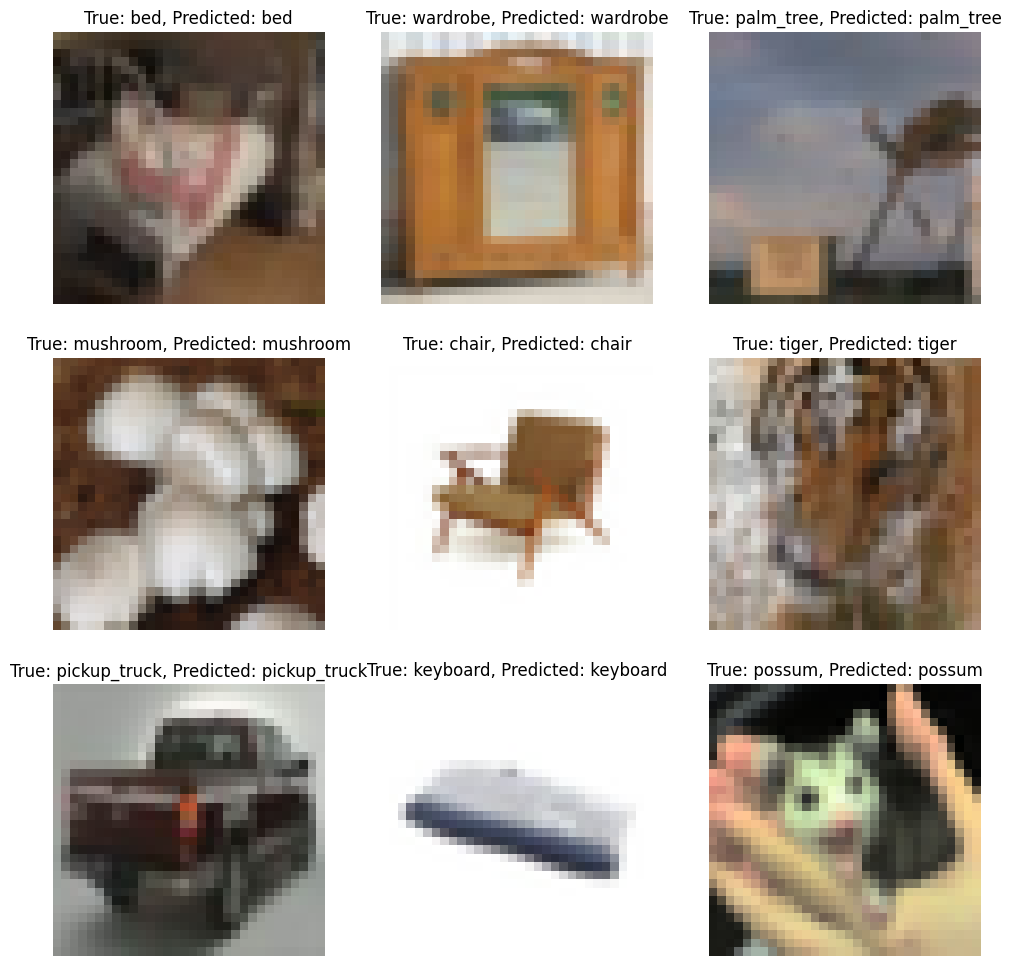

In [ ]:
ds_test_shuffled = ds_test.shuffle(buffer_size=len(ds_test))

for images, labels in ds_test_shuffled.take(1):
    sample_images = images[:9]
    sample_labels = labels[:9]

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f'True: {class_names[sample_labels[i]]}, Predicted: {class_names[predicted_labels[i]]}')
    plt.axis('off')
plt.show()

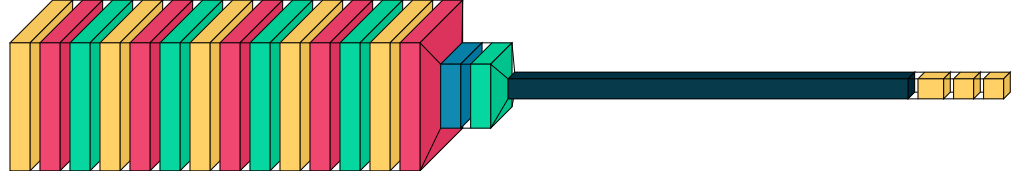

In [ ]:
# visualkeras.layered_view(model)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(24, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='selu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0004),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=25,
    validation_data=ds_test,
)

Epoch 1/25
333/333 [==============================] - 14s 32ms/step - loss: 3.8654 - sparse_categorical_accuracy: 0.1219 - val_loss: 4.9332 - val_sparse_categorical_accuracy: 0.0579
Epoch 2/25
333/333 [==============================] - 12s 35ms/step - loss: 3.1736 - sparse_categorical_accuracy: 0.2368 - val_loss: 3.0426 - val_sparse_categorical_accuracy: 0.2615
Epoch 3/25
333/333 [==============================] - 10s 31ms/step - loss: 2.7986 - sparse_categorical_accuracy: 0.3065 - val_loss: 2.5747 - val_sparse_categorical_accuracy: 0.3595
Epoch 4/25
333/333 [==============================] - 10s 30ms/step - loss: 2.4975 - sparse_categorical_accuracy: 0.3669 - val_loss: 2.4143 - val_sparse_categorical_accuracy: 0.3859
Epoch 5/25
333/333 [==============================] - 10s 30ms/step - loss: 2.2407 - sparse_categorical_accuracy: 0.4214 - val_loss: 2.0267 - val_sparse_categorical_accuracy: 0.4739
Epoch 6/25
333/333 [==============================] - 10s 31ms/step - loss: 2.0224 - spars

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(24, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='selu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0004),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=25,
    validation_data=ds_test,
)

Epoch 1/25
333/333 [==============================] - 25s 30ms/step - loss: 3.8333 - sparse_categorical_accuracy: 0.1285 - val_loss: 5.1927 - val_sparse_categorical_accuracy: 0.0457
Epoch 2/25
333/333 [==============================] - 8s 23ms/step - loss: 3.1179 - sparse_categorical_accuracy: 0.2451 - val_loss: 2.9147 - val_sparse_categorical_accuracy: 0.2883
Epoch 3/25
333/333 [==============================] - 8s 24ms/step - loss: 2.7370 - sparse_categorical_accuracy: 0.3185 - val_loss: 2.5444 - val_sparse_categorical_accuracy: 0.3567
Epoch 4/25
333/333 [==============================] - 8s 24ms/step - loss: 2.4513 - sparse_categorical_accuracy: 0.3743 - val_loss: 2.2907 - val_sparse_categorical_accuracy: 0.4167
Epoch 5/25
333/333 [==============================] - 8s 23ms/step - loss: 2.2093 - sparse_categorical_accuracy: 0.4289 - val_loss: 2.0426 - val_sparse_categorical_accuracy: 0.4744
Epoch 6/25
333/333 [==============================] - 8s 23ms/step - loss: 1.9973 - sparse_cat

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(48, (3,3), padding='same', input_shape=(32, 32, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='selu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00035),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=25,
    validation_data=ds_test,
)

Epoch 1/25
333/333 [==============================] - 53s 41ms/step - loss: 3.6944 - sparse_categorical_accuracy: 0.1561 - val_loss: 4.9311 - val_sparse_categorical_accuracy: 0.0516
Epoch 2/25
333/333 [==============================] - 13s 39ms/step - loss: 2.8053 - sparse_categorical_accuracy: 0.3092 - val_loss: 2.3559 - val_sparse_categorical_accuracy: 0.4036
Epoch 3/25
333/333 [==============================] - 13s 38ms/step - loss: 2.2011 - sparse_categorical_accuracy: 0.4341 - val_loss: 1.8169 - val_sparse_categorical_accuracy: 0.5389
Epoch 4/25
333/333 [==============================] - 13s 38ms/step - loss: 1.7120 - sparse_categorical_accuracy: 0.5482 - val_loss: 1.4635 - val_sparse_categorical_accuracy: 0.6273
Epoch 5/25
333/333 [==============================] - 13s 38ms/step - loss: 1.2721 - sparse_categorical_accuracy: 0.6569 - val_loss: 1.0888 - val_sparse_categorical_accuracy: 0.7385
Epoch 6/25
333/333 [==============================] - 13s 38ms/step - loss: 0.8885 - spars

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(48, (3,3), padding='same', input_shape=(32, 32, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='selu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00035),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=25,
    validation_data=ds_test,
)

In [70]:
# residual neural networks https://arxiv.org/abs/1512.03385

from keras import Model, Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Layer, Conv2D, BatchNormalization, ReLU, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np

class ResBlock(Layer):
    def __init__(self, num_features):
        super(ResBlock, self).__init__()
        self.conv1 = Conv2D(num_features, (3,3), padding='same')
        self.conv2 = Conv2D(num_features, (3,3), padding='same')
        self.bnorm1 = BatchNormalization()
        self.bnorm2 = BatchNormalization()
        self.relu = ReLU()

    def call(self, inputs):
        residual = inputs
        x = self.conv1(inputs)
        x = self.bnorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bnorm2(x)
        x += residual
        x = self.relu(x)
        return x

class ResNet(Model):
    def __init__(self, num_blocks, num_features, in_features, classifier_size):
        super(ResNet, self).__init__()
        self.start_block = Sequential([
            Conv2D(num_features, (3,3), padding='same'),
            BatchNormalization(),
            ReLU()
        ])
        self.blocks = [ResBlock(num_features) for _ in range(num_blocks)]
        self.classifier = Sequential([
            Conv2D(num_features, (3,3)),
            Conv2D(num_features, (3,3)),
            BatchNormalization(),
            ReLU(),
            Flatten(),
            Dense(classifier_size)
        ])

    def call(self, inputs):
        x = self.start_block(inputs)
        for block in self.blocks:
            x = block(x)
        return self.classifier(x)

In [71]:
len_test =  len(ds_test)
combined = ds_train.concatenate(ds_test)
combined = ds_train.shuffle(len(combined))
ds_train = combined.take(int(len(combined)*0.9))
ds_test = combined.skip(int(len(combined)*0.9))

In [72]:
model = ResNet(6, 16, (32, 32, 3), 100)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# lr scheduler, redukuje lr kiedy accuracy przestanie rosnąć (staramy się znaleźć dołek gradientu, więc obniżamy lr)
ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0
)

reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-6)

model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
    callbacks=[reducer]
)

Epoch 1/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - loss: 4.2362 - sparse_categorical_accuracy: 0.0644 - val_loss: 3.2336 - val_sparse_categorical_accuracy: 0.2436 - learning_rate: 0.0010
Epoch 2/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 3.1370 - sparse_categorical_accuracy: 0.2543 - val_loss: 2.4147 - val_sparse_categorical_accuracy: 0.4042 - learning_rate: 0.0010
Epoch 3/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 2.3291 - sparse_categorical_accuracy: 0.4189 - val_loss: 1.6564 - val_sparse_categorical_accuracy: 0.6080 - learning_rate: 0.0010
Epoch 4/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 1.5929 - sparse_categorical_accuracy: 0.5903 - val_loss: 0.8832 - val_sparse_categorical_accuracy: 0.7980 - learning_rate: 0.0010
Epoch 5/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.8866 - sparse_categorical_accuracy: 0.7709 - val_loss: 0.4165 - val_sparse_categorical_accuracy: 0.9067 - learning_rate: 0.0010
Epoch 6/20
176/299 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

1/1 [==============================] - 0s 38ms/step


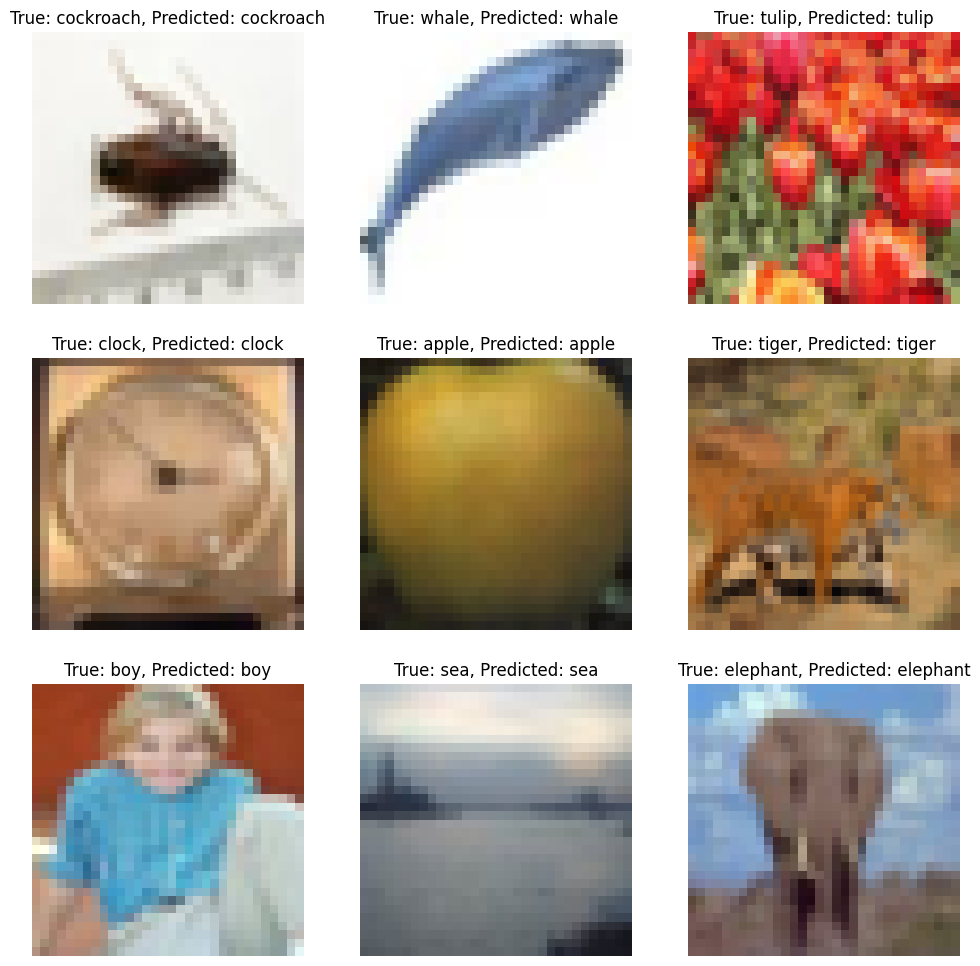

In [ ]:
# mamy 100% pewności na datasecie, co jest dosyć ciekawe i występuje bardzo rzadko.
# pomimo tego, że mamy 100% celności to po spadającym "val_loss" widać, że model uczy się dalej (jest bardziej pewny swoich predykcji)
# najlepszy jest epoch 19

ds_test_shuffled = ds_test.shuffle(buffer_size=len(ds_test))

for images, labels in ds_test_shuffled.take(1):
    sample_images = images[:9]
    sample_labels = labels[:9]

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f'True: {class_names[sample_labels[i]]}, Predicted: {class_names[predicted_labels[i]]}')
    plt.axis('off')
plt.show()